In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from itertools import combinations
from functools import wraps
from collections import Counter
from time import time
import numpy as np

"""pre-processing"""
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

##models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

#auxiliar
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold

In [2]:
df = pd.read_csv("dataset.csv", sep=";", decimal=',')

#to plot graphs used for exploratory data analysis
mk_graphs = True

# to save tables and graphs(images) to be used on the article
save_tables = False
save_images = True
saved_format = "png"

# Fixing the data

In [3]:
#tradução nome dos solos
traducao = {
    'Clay':'Argila',
    'Sand':'Areia',
    'Mining tailing - bauxit': 'Rejeito de Mineração - Bauxita',
    'Silt':'Lodo',
    'Mining tailing - zinc': 'Rejeito de Mineração - Zinco',
    'Peat':'Turfa',
    'Organic clay':'Argila Orgânica',
    'Mining tailing - iron':'Rejeitos de Mineração - Ferro',
    'Mixture of clay and sand':'Mistura de argila e areia',
    'Mining tailing - gold':'Rejeitos de Mineração - Ouro',
}
df['Soil']=df['Soil'].apply(lambda x: traducao[x])
print(df["Soil"].value_counts())

Argila                            1227
Areia                              270
Rejeito de Mineração - Bauxita     159
Lodo                                75
Rejeito de Mineração - Zinco        35
Turfa                               32
Argila Orgânica                     25
Rejeitos de Mineração - Ferro       16
Mistura de argila e areia           14
Rejeitos de Mineração - Ouro         9
Name: Soil, dtype: int64


## drop NaN and duplicates

In [4]:
print(df.isna().sum())
#for col in df:
#    print(col, df[col].isna().sum())

Soil     0
G        0
qt       0
fs       0
u        1
gamma    0
mq       0
Rf       0
dtype: int64


In [5]:
print(df.loc[df['u'].isna()])
print("linha 66 tem um valor invalido para u vazio, abordagem escolhida deleção")
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
print(df.shape)

                              Soil      G     qt      fs   u  gamma      mq  \
66  Rejeito de Mineração - Bauxita  3.037  870.76  16.34 NaN  16.25  43.538   

      Rf  
66  2.22  
linha 66 tem um valor invalido para u vazio, abordagem escolhida deleção
(1860, 8)


2 lines dropped, one without value for u and another that is duplicate

## Fixing negative values

Due to physical proprieties:
- gamma < 50
- fs >= 0
- u >= 0
- rf >= 0

In [6]:
print("before:")
print("X, features:\n", df.describe(), sep='', end="\n\n\n")
print(df["Soil"].value_counts())

before:
X, features:
                 G            qt            fs            u        gamma  \
count  1860.000000    1860.000000  1860.000000  1860.000000  1860.000000   
mean      2.585229    3175.300115    40.869806   518.502909    16.755252   
std       0.330491    8150.218034    96.320841   812.377352     2.756760   
min       1.353000      30.372072    -0.350000 -1000.000000     9.640000   
25%       2.337000     391.945000     6.429856   100.498125    14.900000   
50%       2.620000     841.717956    12.885412   247.833064    16.731174   
75%       2.710000    2786.325000    31.017500   529.412950    18.800000   
max       4.342100  118000.000000  1401.860000  6078.000000    29.894217   

                 mq           Rf  
count   1860.000000  1860.000000  
mean     245.937867     1.970482  
std      678.685435     1.977165  
min       11.440000    -0.100000  
25%       42.662119     0.930000  
50%       65.959375     1.563841  
75%      193.890499     2.381305  
max    12200.0

In [7]:
for col in ('fs', 'u','Rf'):
    df.loc[df.loc[:,col] < 0, col] = 0

In [8]:
y=df["Soil"]
X=df.drop(["Soil"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=0)

## Remove outliers

In [9]:
def return_clean_df(X_train, y_train):
    """
    limpa os dados e retorna
    não altera a coluna gamma e g
    das demais, retira os 2% maior e menor valores
    """
    cols = [i for i in X_train.columns if i not in ('gamma', 'G')]
    aux = (X_train.loc[:,cols])
    Q1 = aux.quantile(q=0.02)
    Q2 = aux.quantile(q=0.99)
    condition = ((aux < Q1) | (aux > Q2))
    X_train_clean = X_train.loc[~condition.any(axis=1)]
    y_train_clean = y_train.loc[~condition.any(axis=1)]
    return X_train_clean , y_train_clean

In [10]:
X_train_clean , y_train_clean = return_clean_df(X_train, y_train)

print("after:")
if save_tables:
    out = X_train_clean.describe()
    out.style \
      .format(precision=3, thousands=".", decimal=",").\
      to_excel('distribuicao_estatistica_depois.xlsx', engine='xlsxwriter')
else:
    print("X, features:\n", X_train_clean.describe(), sep='', end="\n\n\n")

after:
X, features:
                 G           qt            fs            u        gamma  \
count  1338.000000   1338.000000  1338.000000  1338.000000  1338.000000   
mean      2.582102   2348.614021    32.564714   511.158578    16.773181   
std       0.320318   3783.807400    52.229420   699.667375     2.664731   
min       1.450000    106.612000     1.491611     0.000000     9.840000   
25%       2.280000    427.268172     7.122500   119.450650    15.018149   
50%       2.620000    883.560000    13.382431   266.480000    16.754800   
75%       2.701000   2505.986351    30.178750   555.881075    18.683473   
max       4.342100  34507.383860   373.493976  4155.000000    29.894217   

                mq           Rf  
count  1338.000000  1338.000000  
mean    182.631103     1.900391  
std     333.445352     1.374958  
min      23.557171     0.210000  
25%      43.449573     0.981479  
50%      67.066328     1.606243  
75%     176.906671     2.361138  
max    3142.872250     9.065429 

In [11]:
y_out= pd.DataFrame(y.value_counts())
y_out.style \
  .format(precision=3, thousands=".", decimal=",").\
  to_excel('contagem_solos_dataset.xlsx', engine='xlsxwriter')


In [12]:
print("before:")
if save_tables:
    out = X_train.describe()
    out.style \
      .format(precision=3, thousands=".", decimal=",").\
      to_excel('distribuicao_estatistica_antes.xlsx', engine='xlsxwriter')
else:
    print("X, features:\n", X_train_clean.describe(), sep='', end="\n\n\n")

before:
X, features:
                 G           qt            fs            u        gamma  \
count  1338.000000   1338.000000  1338.000000  1338.000000  1338.000000   
mean      2.582102   2348.614021    32.564714   511.158578    16.773181   
std       0.320318   3783.807400    52.229420   699.667375     2.664731   
min       1.450000    106.612000     1.491611     0.000000     9.840000   
25%       2.280000    427.268172     7.122500   119.450650    15.018149   
50%       2.620000    883.560000    13.382431   266.480000    16.754800   
75%       2.701000   2505.986351    30.178750   555.881075    18.683473   
max       4.342100  34507.383860   373.493976  4155.000000    29.894217   

                mq           Rf  
count  1338.000000  1338.000000  
mean    182.631103     1.900391  
std     333.445352     1.374958  
min      23.557171     0.210000  
25%      43.449573     0.981479  
50%      67.066328     1.606243  
75%     176.906671     2.361138  
max    3142.872250     9.065429

In [13]:
y_out= pd.DataFrame(y_train.value_counts())
y_out.style \
  .format(precision=3, thousands=".", decimal=",").\
  to_excel('contagem_solos_antes.xlsx', engine='xlsxwriter')



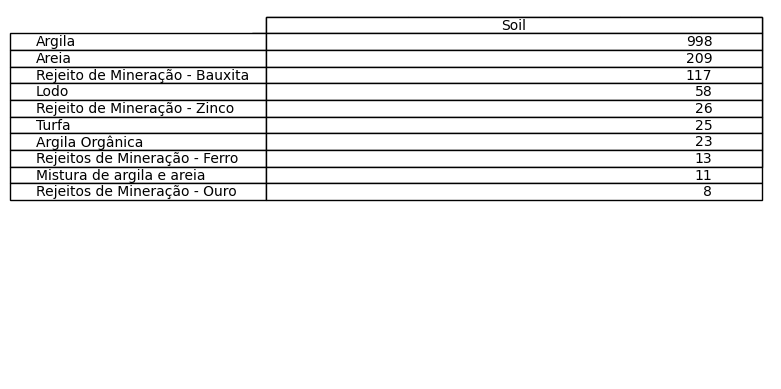

In [14]:
from pandas.plotting import table

def save_table(desc, title):
    #create a subplot without frame
    plot = plt.subplot(111, frame_on=False)

    #remove axis
    plot.xaxis.set_visible(False) 
    plot.yaxis.set_visible(False) 

    #create the table plot and position it in the upper left corner
    table(plot, desc,loc='upper right')

    #save the plot as a png file
    plt.savefig(fname=title, dpi=300, format=saved_format)

if save_images:
    save_table(X_train.describe(), "statistical_parameters")
    save_table(y_train.value_counts(), "count_of_soil_types")

In [15]:
#encoding output
def encode_y (y_train_clean, y_test):
    """
    encoding para os solos
    algoritmos de classifiação usados não necessitam que seja usado one-hot encoding
    então foi usado encoding numérico atribuindo valores de 0 a 9 as classes
    """
    label_encoder = LabelEncoder()
    label_encoder.fit(y_train_clean)
    y_train_encoded = label_encoder.transform(y_train_clean)
    y_test_encoded = label_encoder.transform(y_test)
    return label_encoder, y_train_encoded, y_test_encoded

label_encoder, y_train_encoded, y_test_encoded = encode_y(y_train_clean, y_test)


# brief overview:

# plots

In [16]:
def make_kde(x):
    """
    uses sns.kdeplot to show the distribution of observations for each variable
    plots 3 columns in each line
    """
    for i, col in enumerate(X_train_clean):
        if i%3==2:
            plt.subplot(133)
        elif i%3==1:
            plt.subplot(132)
        else:
            plt.figure(figsize=(13,5))
            plt.subplot(131)
        sns.kdeplot(X_train_clean[col])
        plt.title(col)
        if save_images:
            plt.savefig(fname=f"kde_plot{(i//3)}", dpi=100, format=saved_format)
    plt.show()


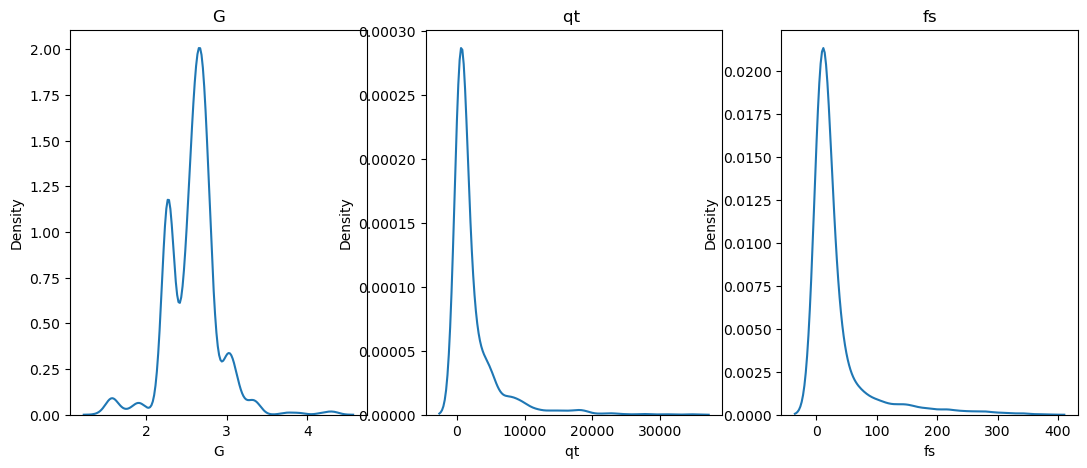

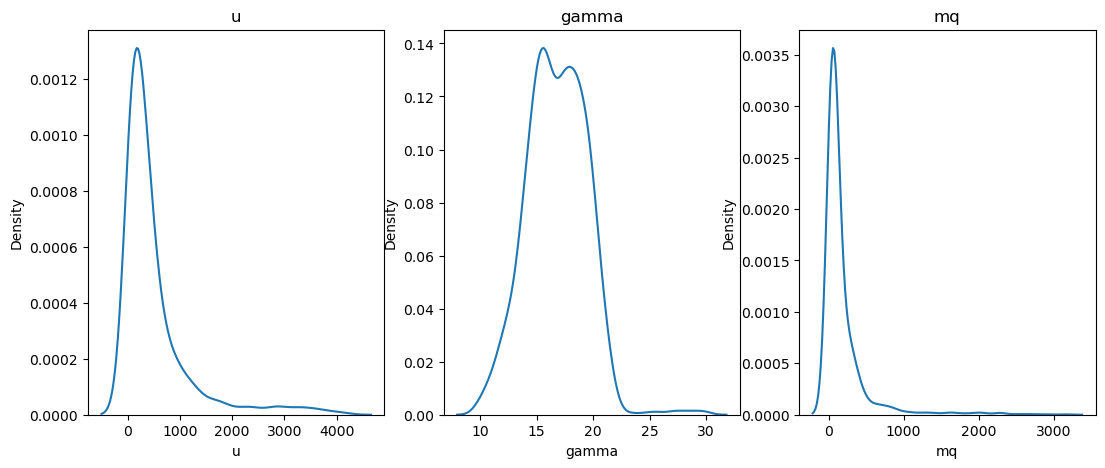

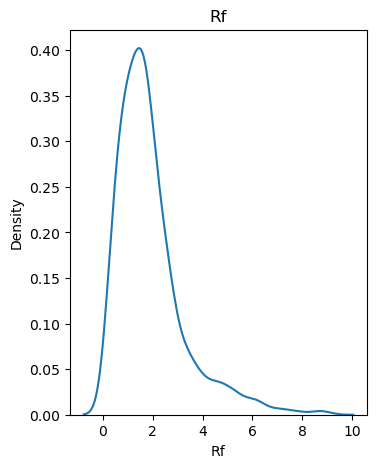

In [17]:
if mk_graphs:
    make_kde(X_train_clean)

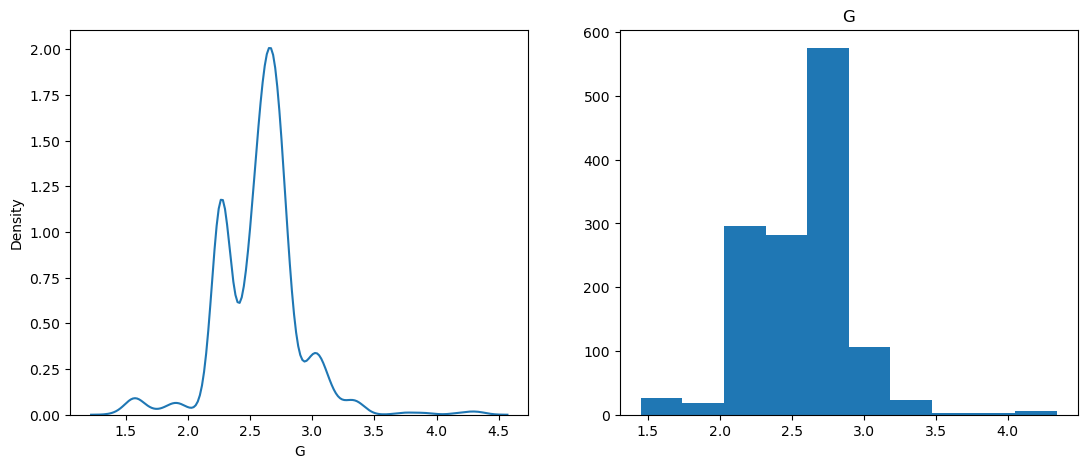

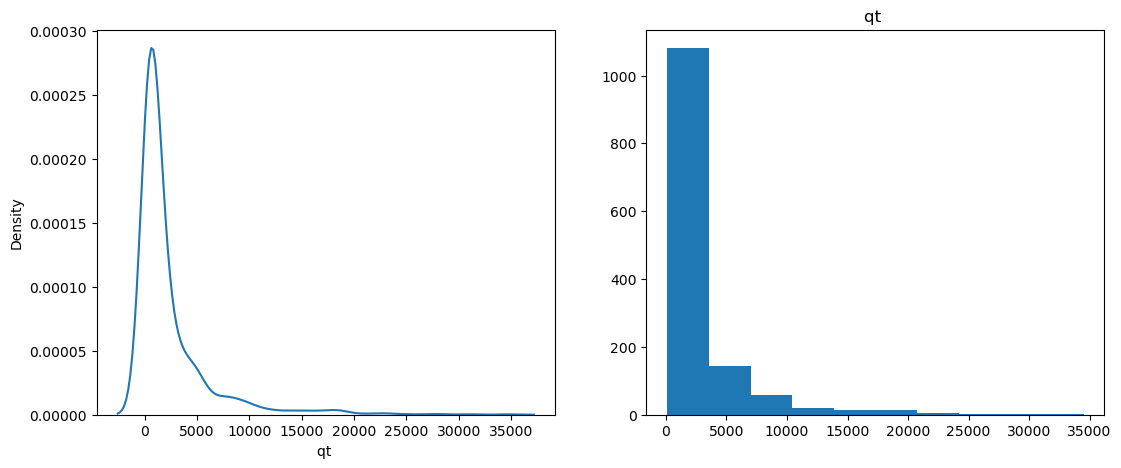

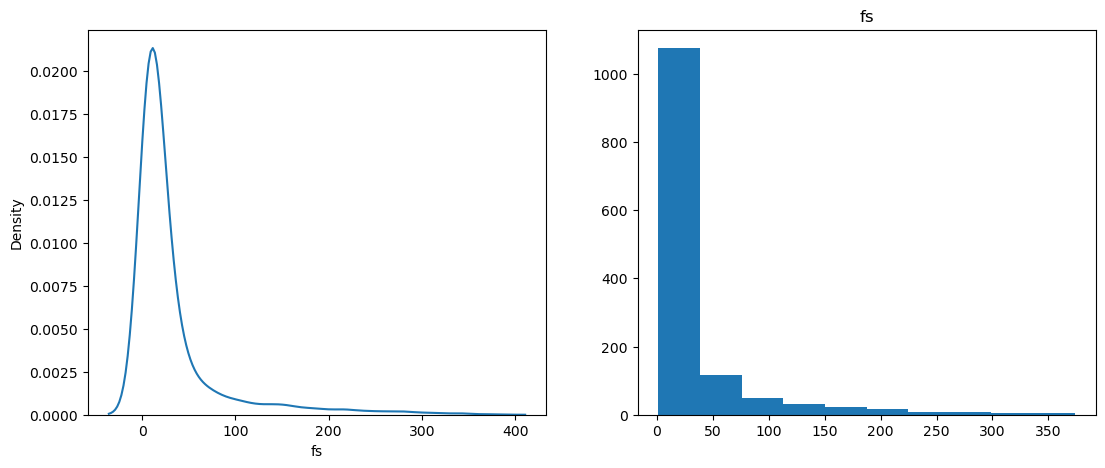

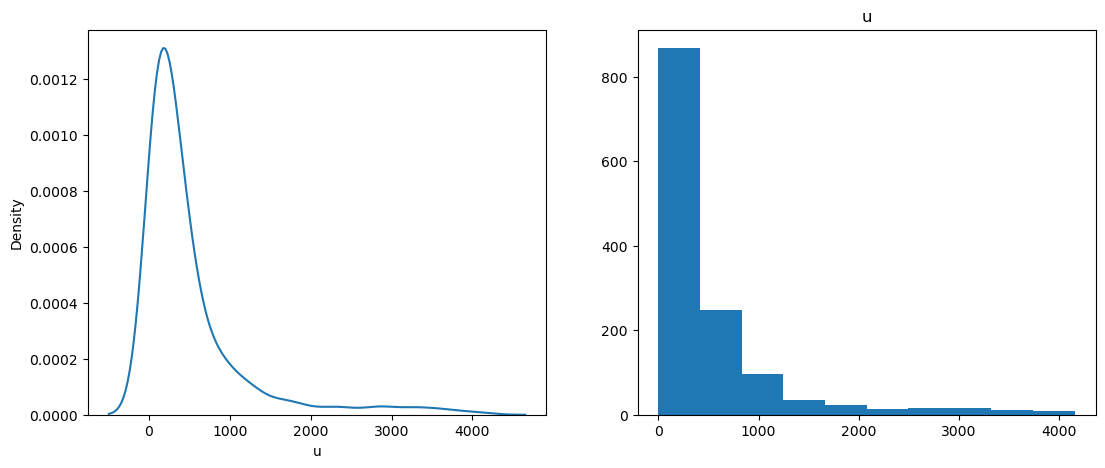

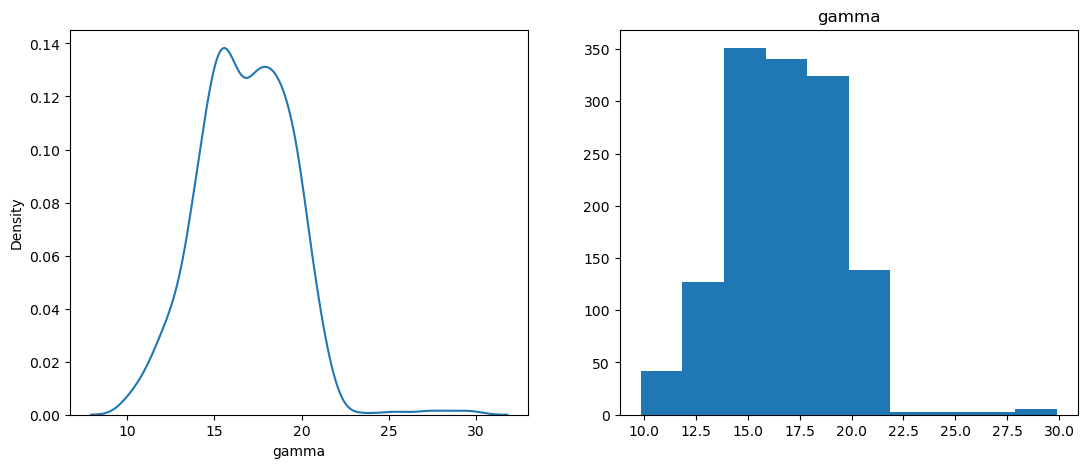

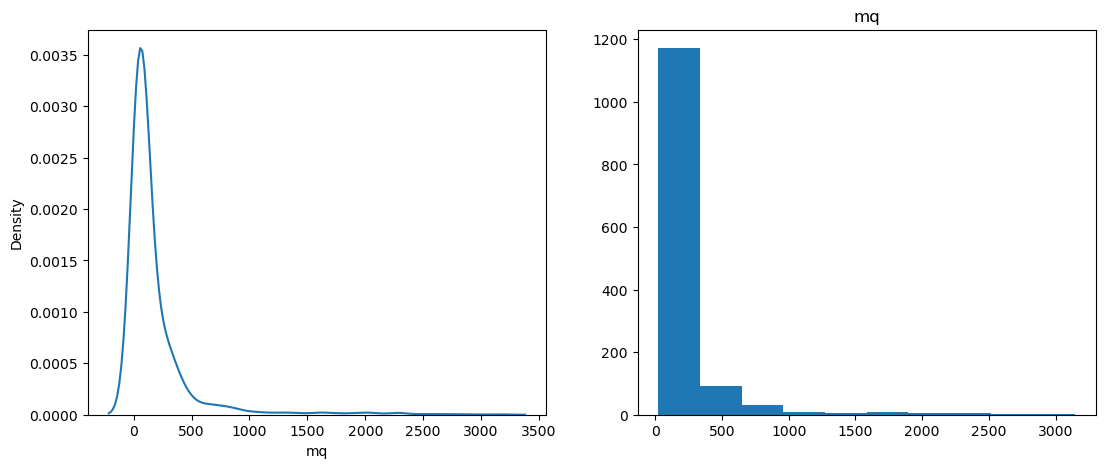

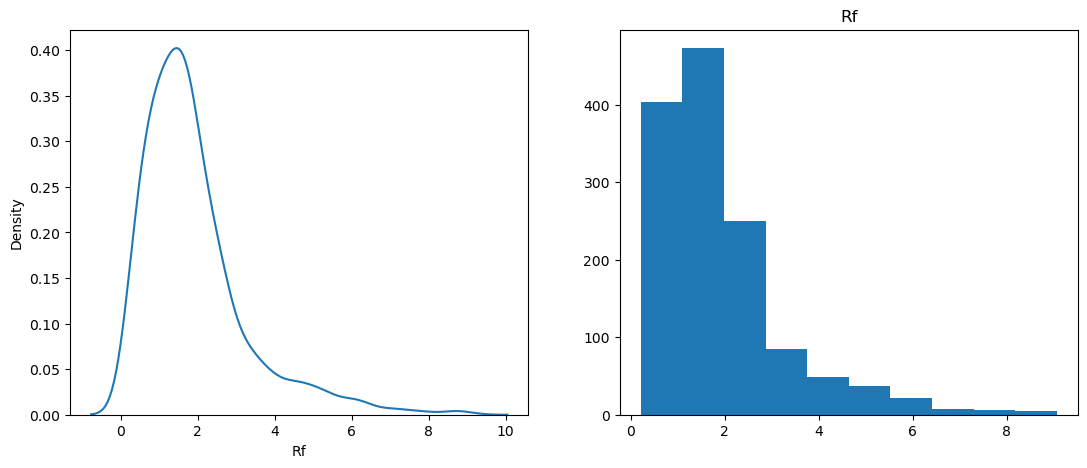

In [18]:
def plot_distribution(series):
    """
    plots a kde and histogram of each column side by side
    """
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    sns.kdeplot(series)
    plt.subplot(122)
    plt.hist(series)
    plt.title(col)
    if save_images:
        plt.savefig(fname=f"distribution_plot_{series.name.strip()}", dpi=100, format=saved_format)
    plt.show()

if mk_graphs:
    for col in X_train_clean:
        plot_distribution(X_train_clean[col])

As distribution is more exponential-like with a long tail method chosen for transformation is box-cox

In [19]:
def plots_transform(df, var, t):
    """
    params:
        df -> dataframe
        var -> column to plot
        t -> transformer from sklearn.preprocessing  
    """
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    sns.kdeplot(df[var])
    plt.title('before ' + str(t).split('(')[0])
    
    plt.subplot(122)
    p1 = t.fit_transform(df[[var]]).flatten()
    sns.kdeplot(p1)
    plt.title('after ' + str(t).split('(')[0])
    if save_images:
        fig_sufix = next(aux_to_save_image)
        plt.savefig(fname=f"plot_transform{(fig_sufix//2)}", dpi=100, format=saved_format)

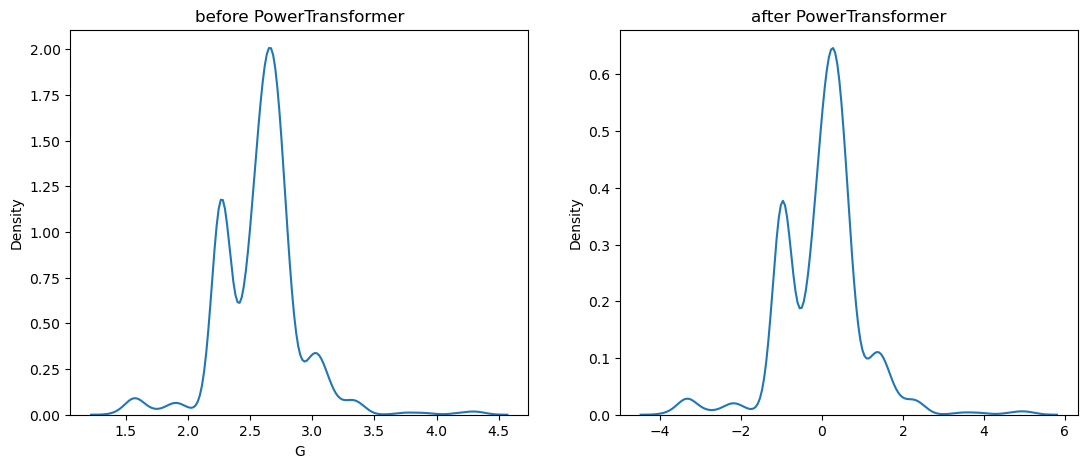

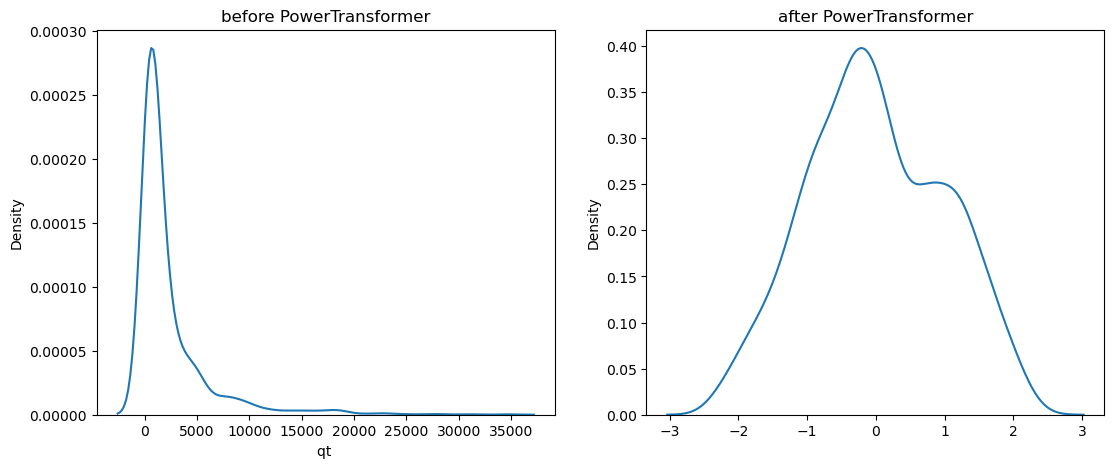

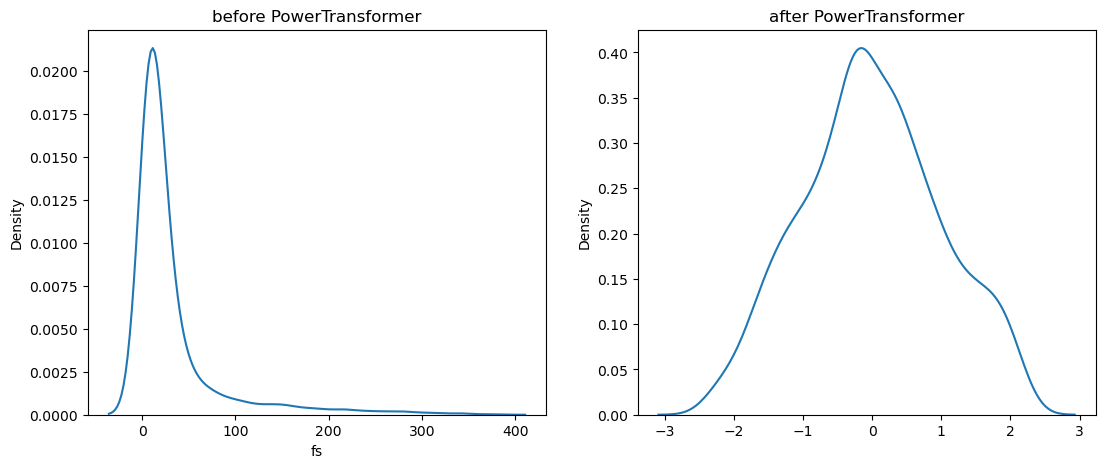

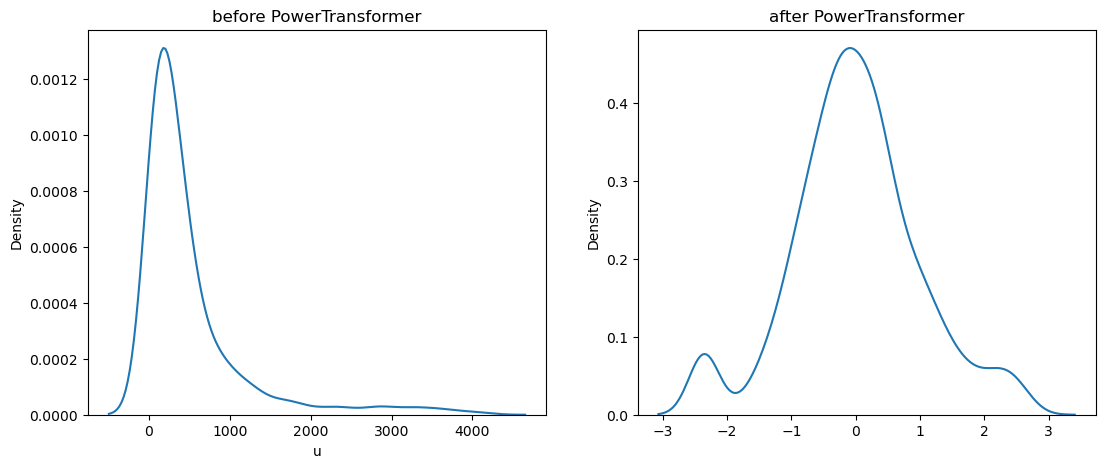

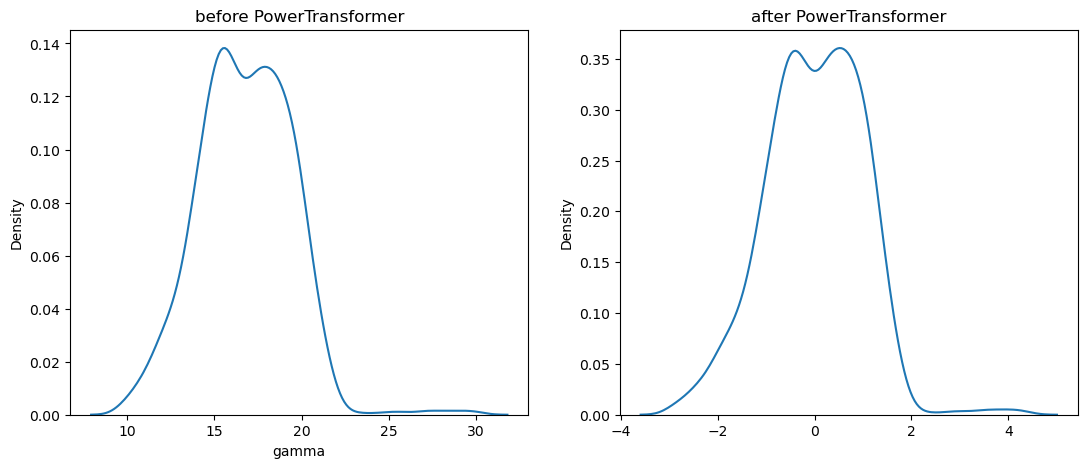

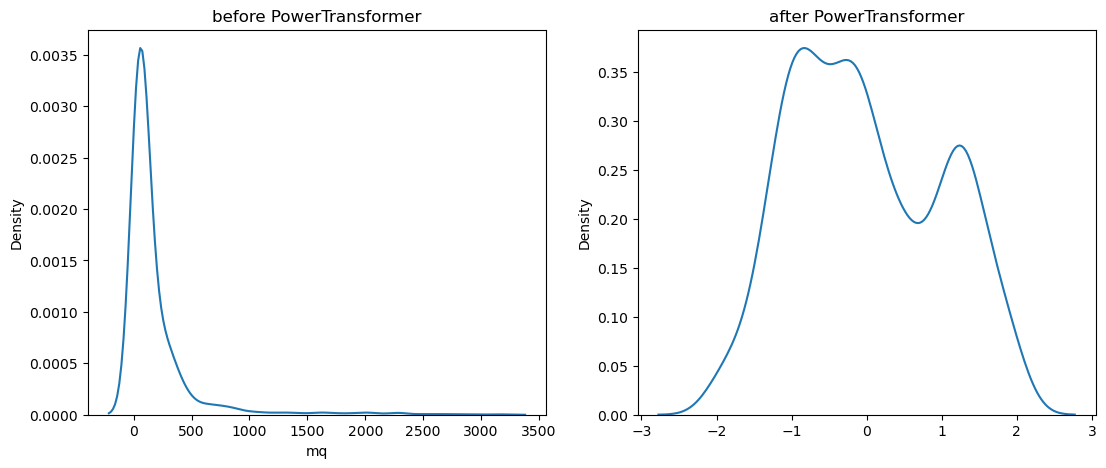

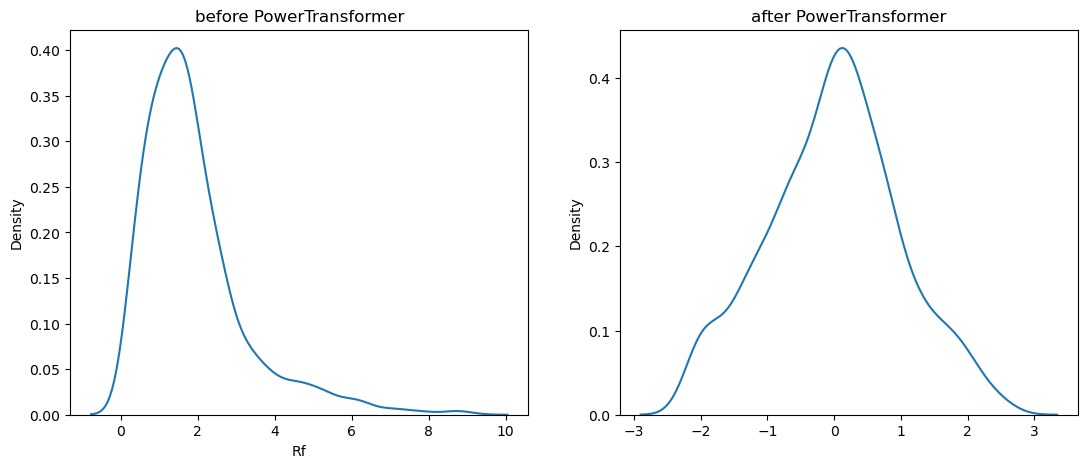

In [20]:
if mk_graphs:
    aux_to_save_image= iter((range(1,len(df.columns))))
    for col in X_train_clean:
        plots_transform(X_train_clean, col, t=PowerTransformer(method="yeo-johnson"))
    #mostrar resultado
    # referencia que aponte
    plt.show()

# Scatter plot

/tmp/ipykernel_10544/361735528.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8,8))


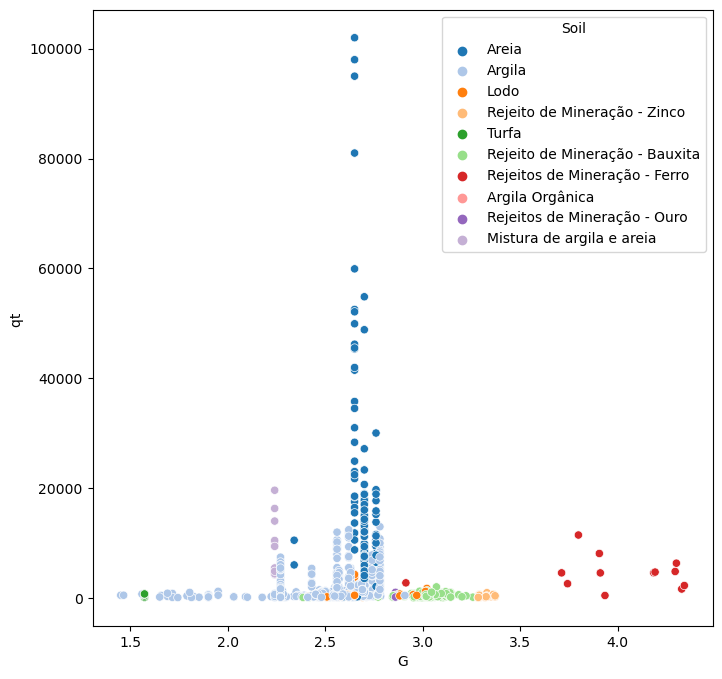

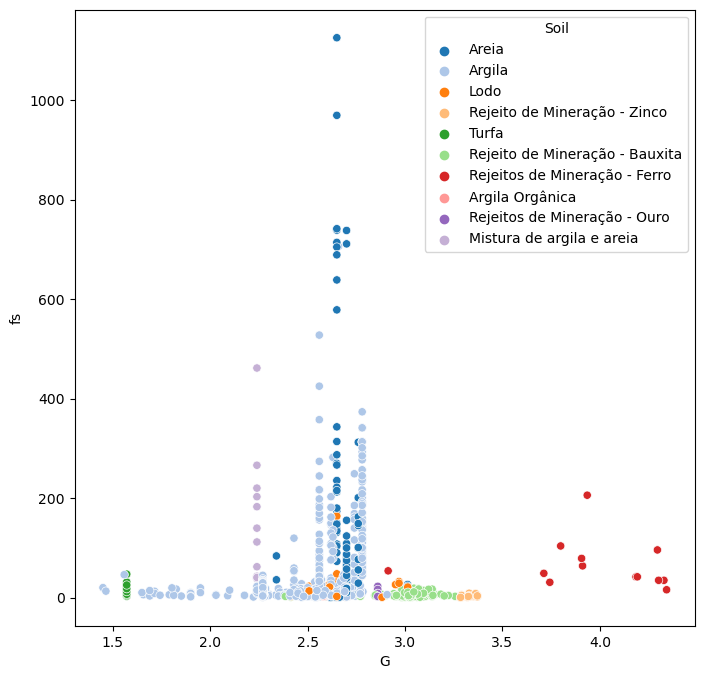

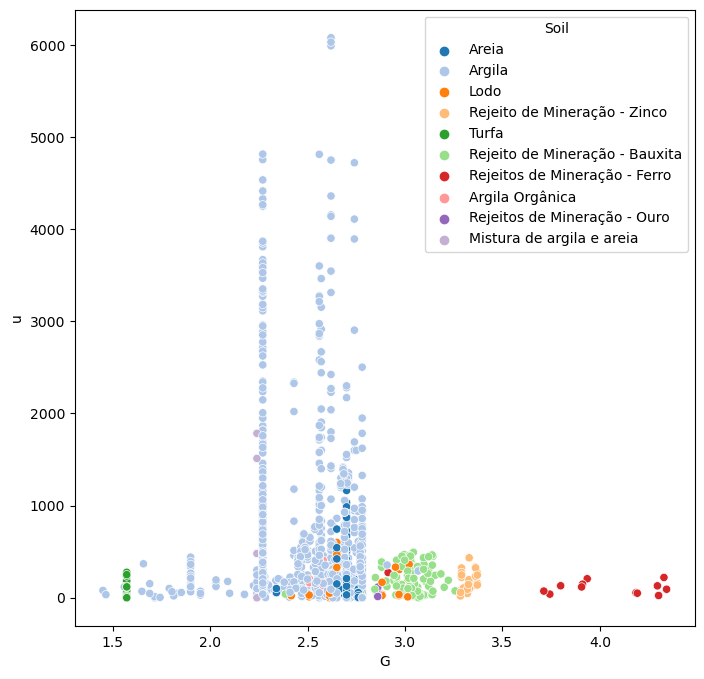

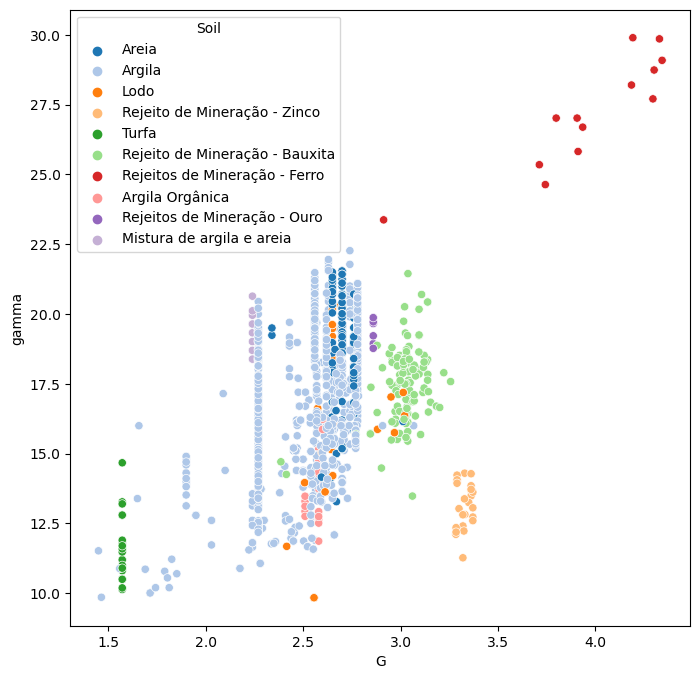

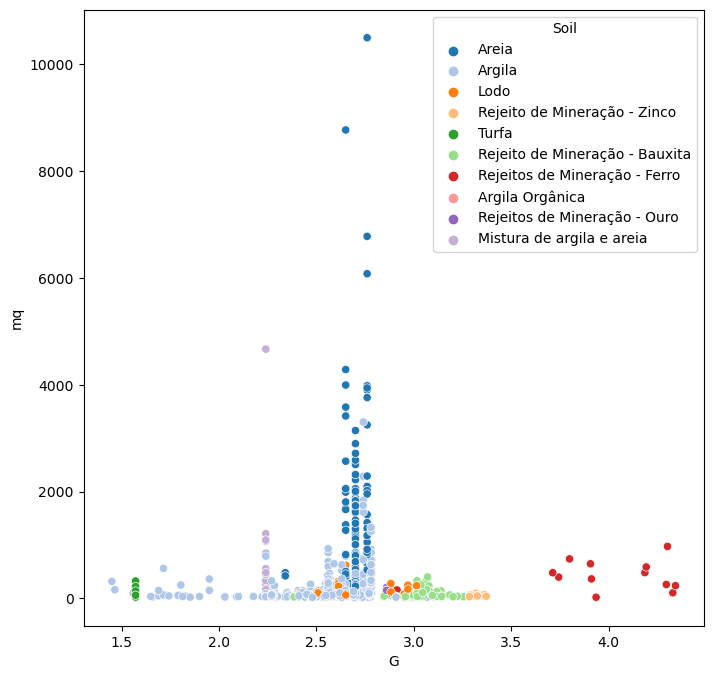

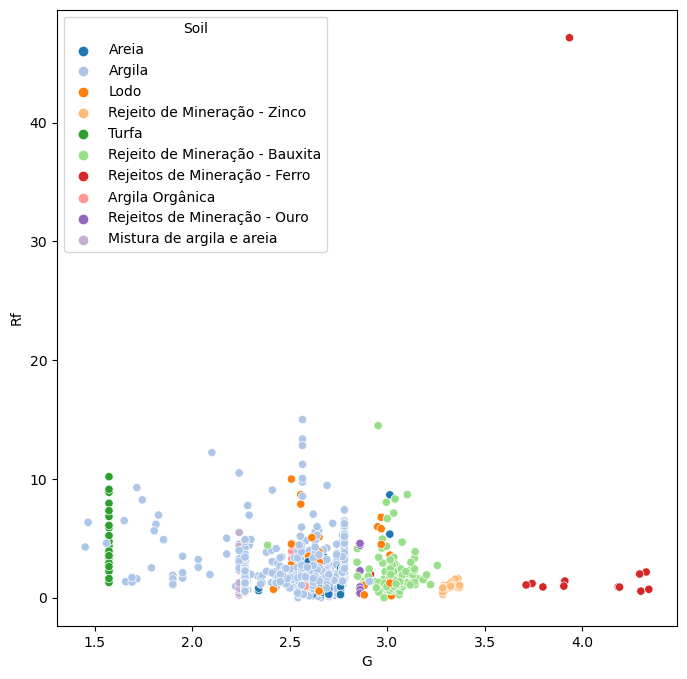

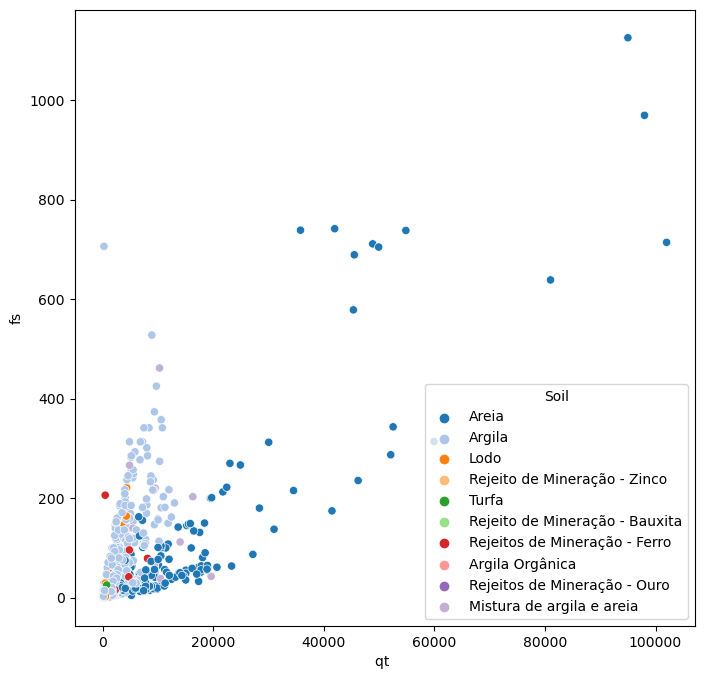

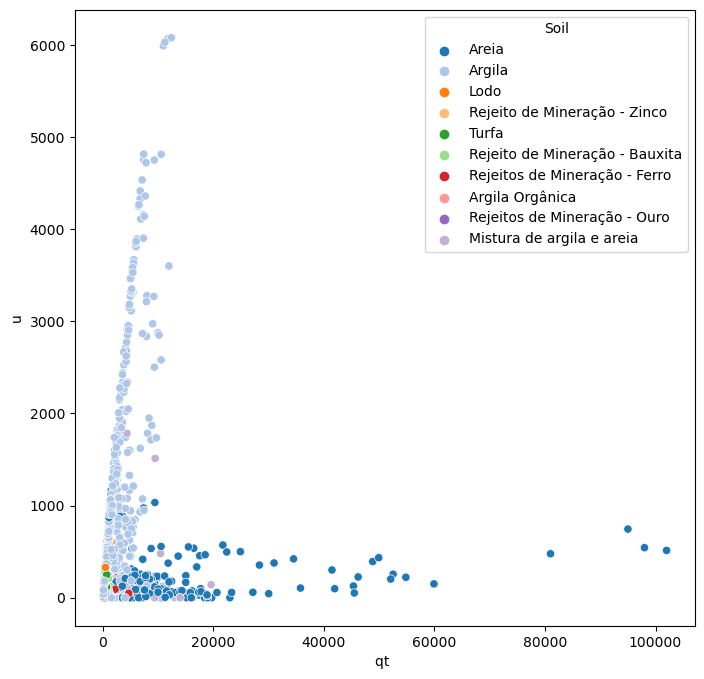

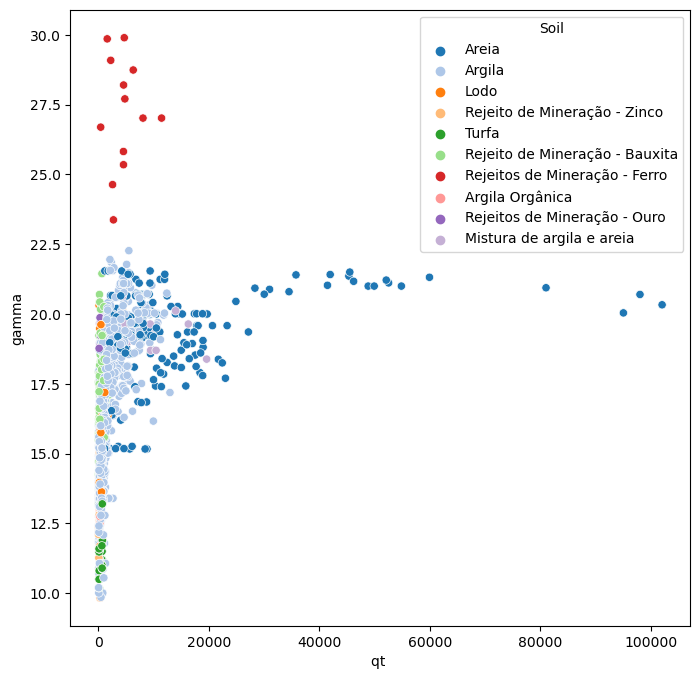

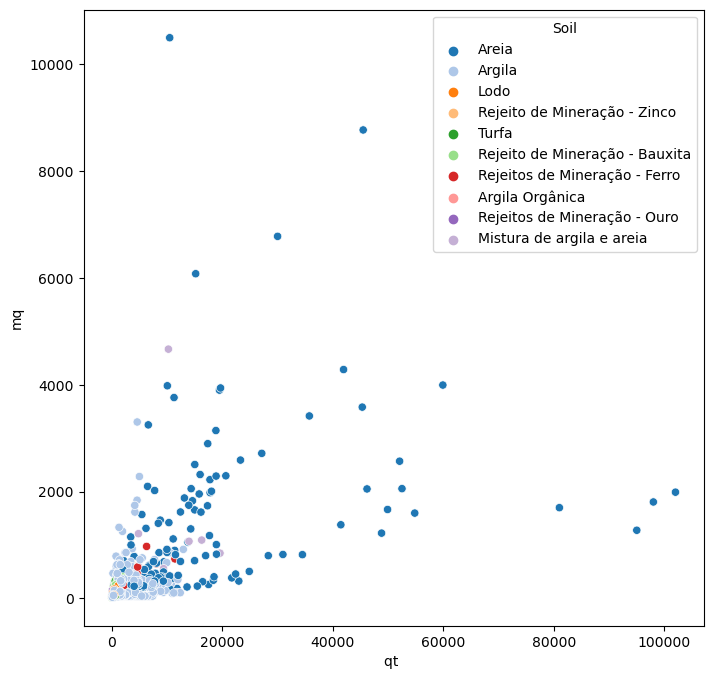

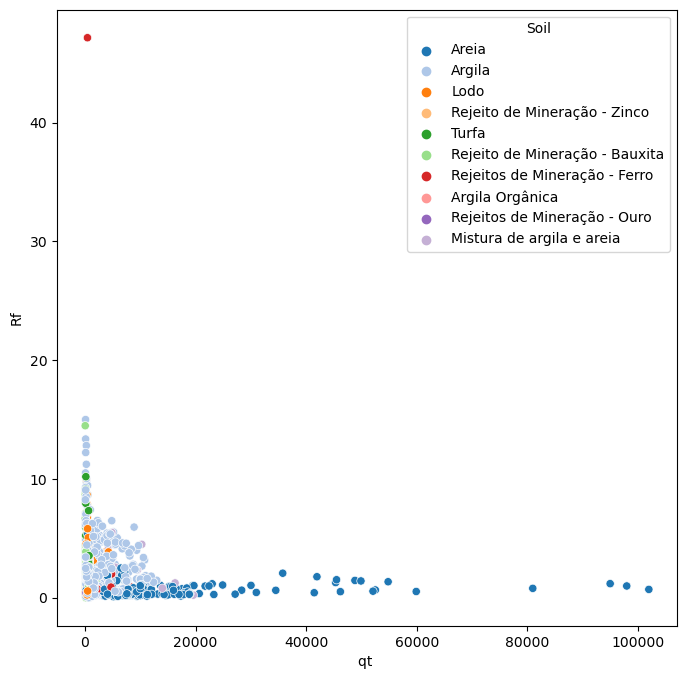

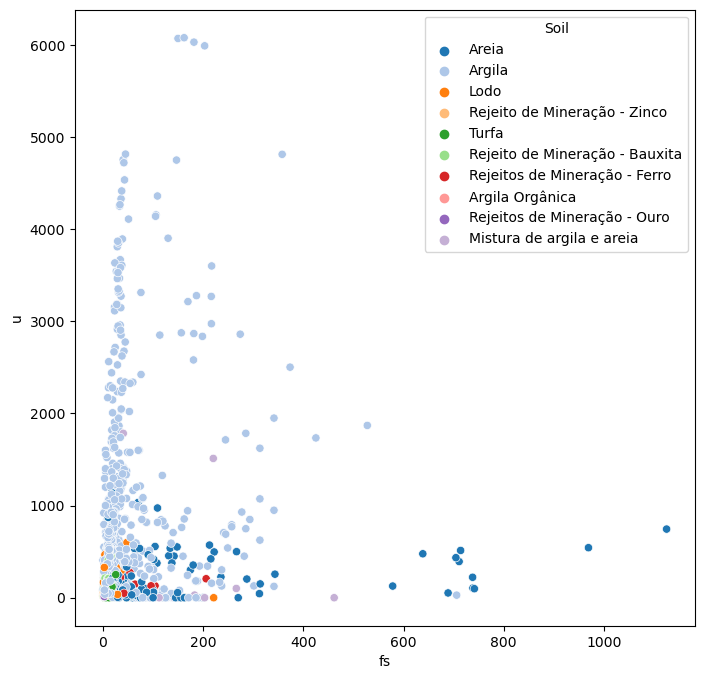

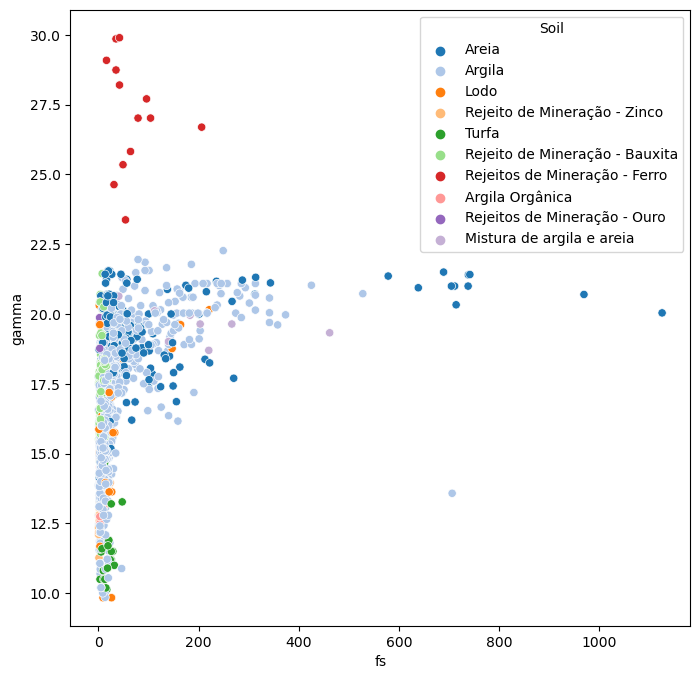

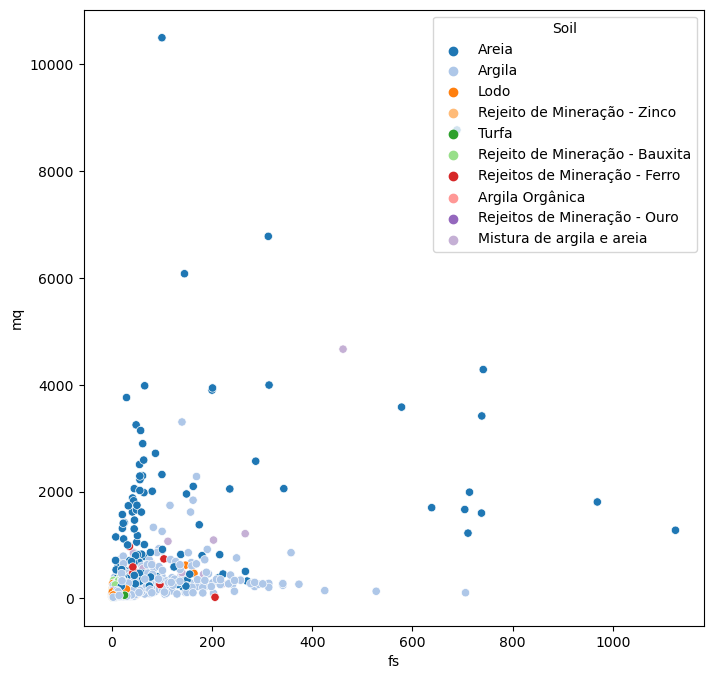

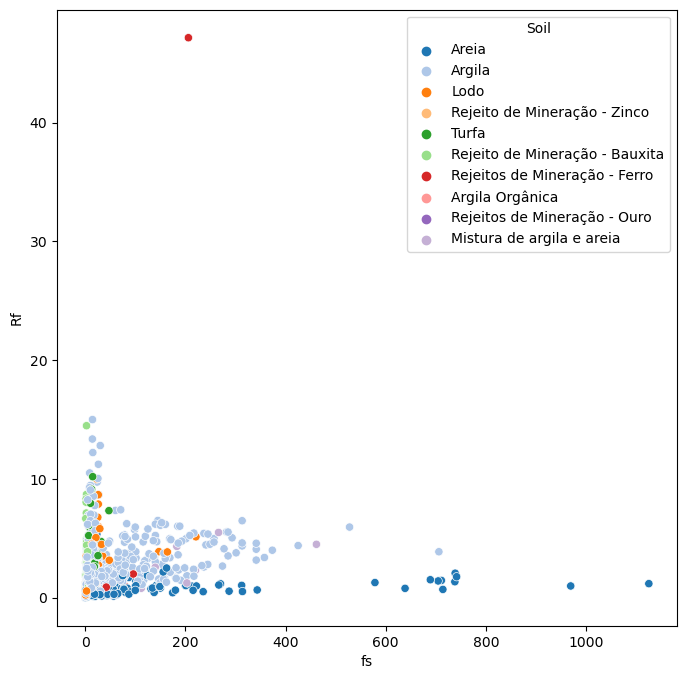

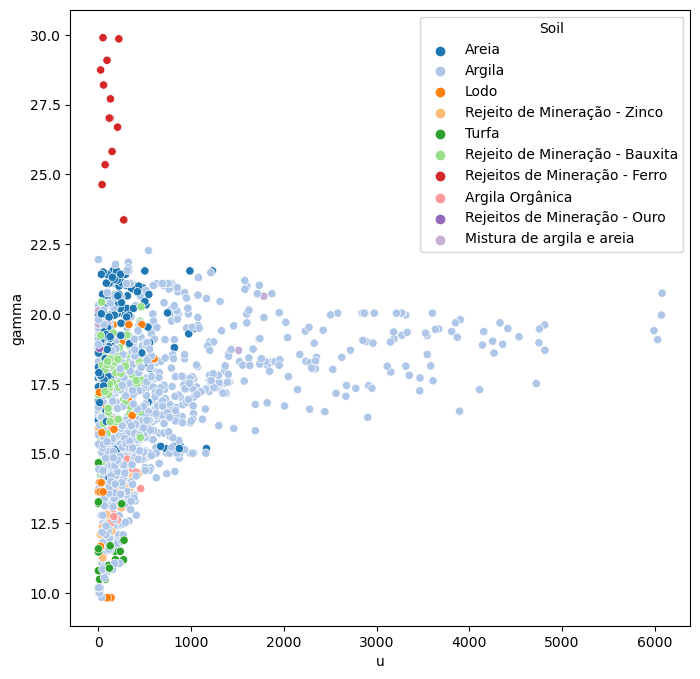

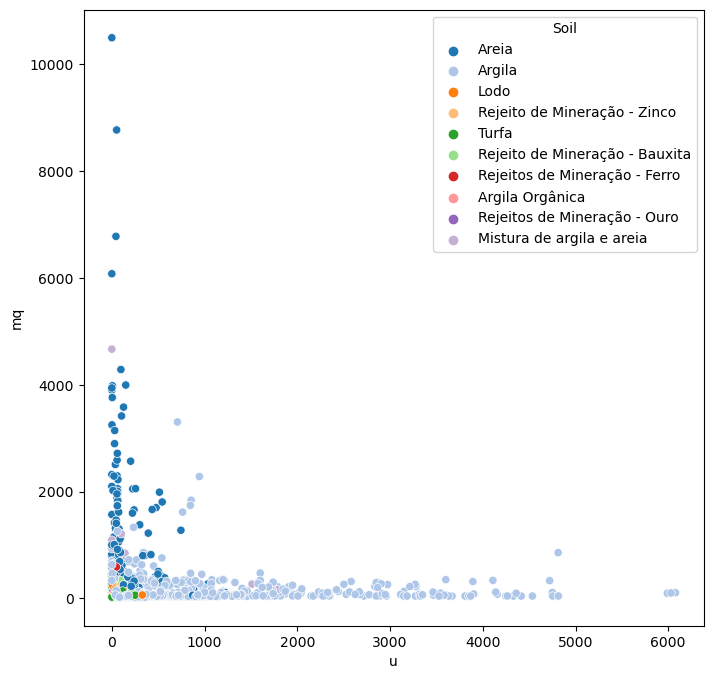

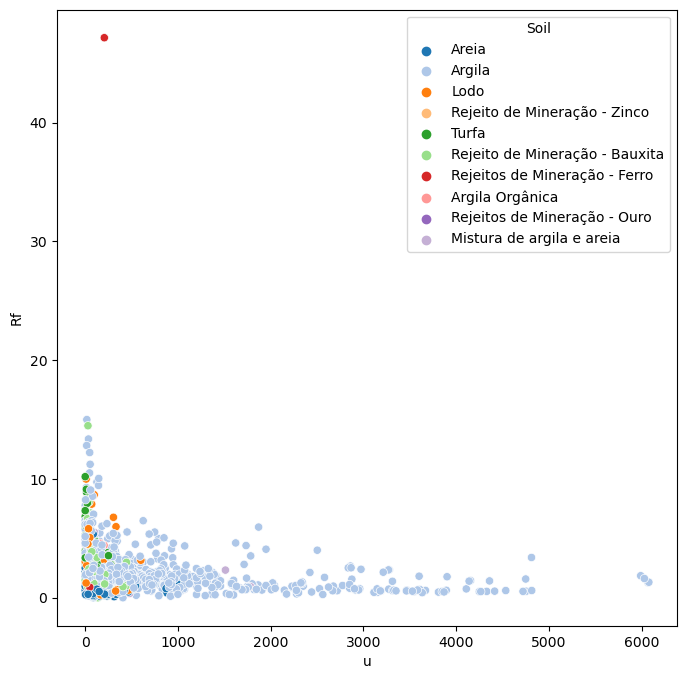

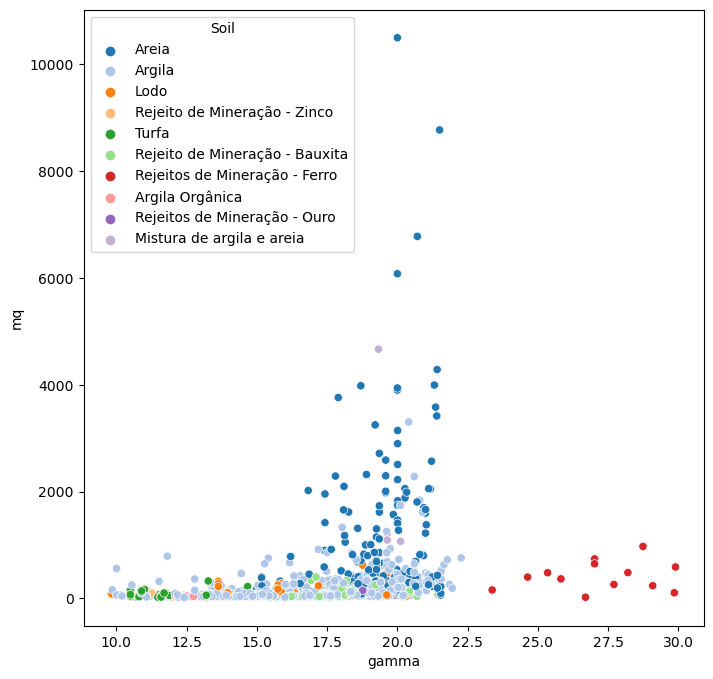

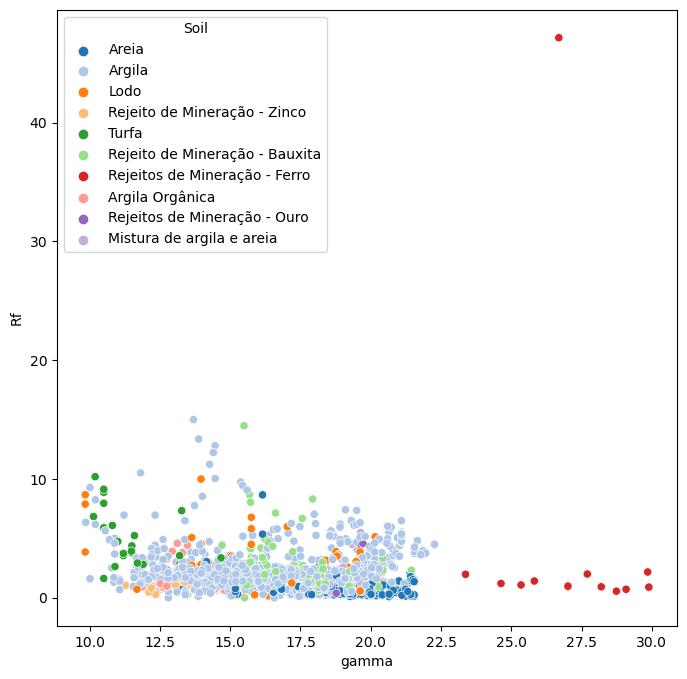

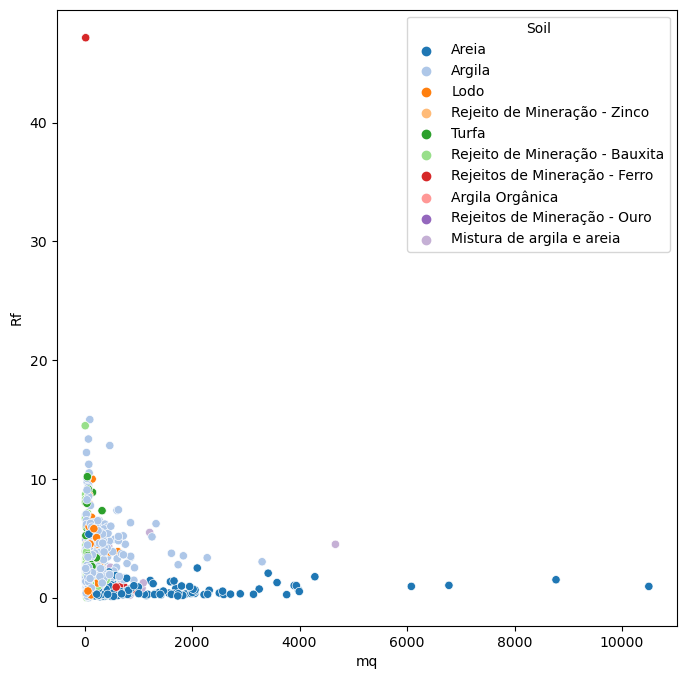

In [21]:
"""
    makes a scatter plot of the every combination of two columns
    colors are given by the class of the observation

"""
if mk_graphs:
    comb = list(combinations(X_train.columns, 2))
    plts_total=int(len(X_train.columns)*(len(X_train.columns)-1)/2)
    for items in comb:
        plt.figure(figsize=(8,8))
        sns.scatterplot(data=X_train, x=items[0], y=items[1], hue=y_train, palette="tab20")
        if save_images:
            plt.savefig(fname=f"scatter_{items[0]}_vs_{items[1].strip()}", dpi=100, format=saved_format)
    plt.show()



# Balancing using SMOTE

In [22]:
X_train_sm, y_train_encoded_sm = SMOTE(random_state=0).fit_resample(X_train_clean, y_train_encoded)


# Model

### timing


In [23]:
def measure(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        t = time()
        result = func(*args, **kwargs)
        print('modeling time', time() - t)
        return result
    return wrapper

## Just accuracy
linear model improve accuracy when using yeo-johnson transformer

In [24]:
#@measure
def model_accuracy(mod):
    """
    measure accuracy of model scaling using yeo-johnson transformer
    uses the train dataset to model and evaluate performance on test dataset
    """
    model_scaled = Pipeline([
        ('scale', PowerTransformer(method='yeo-johnson')),
        ('model', mod)
    ])
    model_scaled.fit(X_train_clean, y_train_encoded)
    return model_scaled.score(X_test, y_test_encoded)

#@measure
def model_accuracy_unscaled(mod):
    """
    measure accuracy of model scaling using yeo-johnson transformer
    uses the train dataset to model and evaluate performance on test dataset
    """
    model_unscaled = Pipeline([
        ('model', mod)
    ])
    model_unscaled.fit(X_train_clean, y_train_encoded)
    return model_unscaled.score(X_test, y_test_encoded)

In [25]:
models = [(DecisionTreeClassifier, dict(random_state=0)),\
  (RandomForestClassifier, dict()), \
  (KNeighborsClassifier, dict()), \
  (LogisticRegression, dict(random_state=0, max_iter=400, multi_class='multinomial')),
  (GaussianNB, dict())]

In [26]:
results = {}
for mod, args in models:
    scaled = model_accuracy(mod(**args))
    unscaled = model_accuracy_unscaled(mod(**args))
    results[mod.__name__] = [scaled, unscaled]
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.rename(columns={0:'Escalado', 1:'Inalterado'}, inplace=True)
results_df['diferenca'] = results_df['Escalado']-results_df['Inalterado']

/home/alberthus/anaconda3/envs/TCC/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
if save_tables:
    results_df.style \
      .format(precision=3, thousands=".", decimal=","). \
      to_excel('performance_scaling.xlsx', engine='xlsxwriter')
else:
    print( results_df )
    

                        Escalado  Inalterado  diferenca
DecisionTreeClassifier  0.905914    0.908602  -0.002688
RandomForestClassifier  0.935484    0.932796   0.002688
KNeighborsClassifier    0.892473    0.728495   0.163978
LogisticRegression      0.881720    0.741935   0.139785
GaussianNB              0.825269    0.599462   0.225806


In [28]:
def model_cross_val(mod):
    """
    param:
        mod: model to be used
    use cross-validation to evaluate model performance, every model uses yeo-johnson scaling
    return a tuple containing the average accuracy, recall and f1-score respectively
    """
    model_scaled = Pipeline([
        ('scale', PowerTransformer(method='yeo-johnson')),
        ('model', mod)
    ])
    accuracy=[]
    recall=[]
    f1=[]
    # 5 divisões para cross validation, StratifiedKFold mantém a proporção de 'labels'/classes em cada partição
    kfolds = StratifiedKFold(n_splits=5)
    #usando os dados limpos para fazer a divisão do array
    for train_index, test_index in kfolds.split(X_train_clean, y_train_clean): 
        #oversampling
        X_train_smote, y_train_encoded_smote = SMOTE(random_state=0).fit_resample(X_train_clean.iloc[train_index], y_train_encoded[train_index])
        # treinando modelo
        model_scaled.fit(X_train_smote, y_train_encoded_smote)
        # avaliando resultados
        y_test_predict = model_scaled.predict(X_train_clean.iloc[test_index])
        accuracy.append(accuracy_score(y_test_predict, y_train_encoded[test_index]))
        recall.append(recall_score(y_test_predict, y_train_encoded[test_index], average='macro', zero_division=1))
        f1.append(f1_score(y_test_predict, y_train_encoded[test_index], average='macro', zero_division=1))
    return  np.mean(accuracy), np.mean(recall), np.mean(f1)


In [29]:
results = {}
for mod, args in models:
    aux = model_cross_val(mod(**args))
    results[mod.__name__] = list(aux)
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.rename(columns={0:'Accuracy', 1:'Recall', 2:'f1-score'}, inplace=True)
#print(results_df)


In [30]:
if save_tables:
    results_df.style \
      .format(precision=3, thousands=".", decimal=","). \
      to_excel('cross_val_score.xlsx', engine='xlsxwriter')
else:
    print(results_df)

                        Accuracy    Recall  f1-score
DecisionTreeClassifier  0.893138  0.867518  0.865918
RandomForestClassifier  0.928244  0.900266  0.860941
KNeighborsClassifier    0.830348  0.716013  0.755513
LogisticRegression      0.679390  0.624819  0.664007
GaussianNB              0.702532  0.784263  0.790734


## Confusion Matrix

In [31]:
#@measure
def model_confusion_matrix(mod, smote):
    """
        param:
            mod: model used to predict
            smote: True, False - if SMOTE will be used or not.
    """
    model_scaled = Pipeline([
        ('scale', PowerTransformer(method='yeo-johnson')),
        ('model', mod)
    ])
    if smote:
        x_aux, y_aux = X_train_sm, y_train_encoded_sm
    else:
        x_aux, y_aux = X_train, y_train_encoded

    model_scaled.fit(x_aux, y_aux)
    y_predict = model_scaled.predict(X_test)
    conf_matrix = confusion_matrix(y_test_encoded, y_predict )
    return conf_matrix

def plot_confusion_matrix(conf_matrix, model_name):
    """
    plot confusion matrix as an nice pretty image
    """
    title = "matriz de confusao " + model_name
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
    disp.plot()
    plt.xticks(rotation = 90)
    plt.title(title)
    if save_images:
        plt.savefig(fname="confusion matrix " + model_name, dpi=150, format=saved_format)
    plt.show()
    
    

In [32]:
def accuracy_per_class():
    """
        makes a table of accuracy for each class label

    """
    count = Counter(list(y_test_encoded))
    results = {}
    for mod, args in models:
        cm = model_confusion_matrix(mod(**args),True)
        results[mod.__name__] = cm.diagonal()/cm.sum(axis=1)*100
    results_df = pd.DataFrame.from_dict(results)
    results_df['Solos'] = label_encoder.classes_
    results_df['Amostras']=np.zeros(10)
    for k in range(10): 
        results_df.loc[k, 'Amostras'] = count[k]
    y_out=results_df.set_index('Solos')
    if save_tables:
        y_out.style \
          .format(precision=3, thousands=".", decimal=",").\
          to_excel('resultados por solo.xlsx', engine='xlsxwriter')
    else:
        print(y_out)

accuracy_per_class()

                                DecisionTreeClassifier  \
Solos                                                    
Areia                                        88.524590   
Argila                                       93.886463   
Argila Orgânica                             100.000000   
Lodo                                         70.588235   
Mistura de argila e areia                   100.000000   
Rejeito de Mineração - Bauxita               97.500000   
Rejeito de Mineração - Zinco                100.000000   
Rejeitos de Mineração - Ferro               100.000000   
Rejeitos de Mineração - Ouro                100.000000   
Turfa                                       100.000000   

                                RandomForestClassifier  KNeighborsClassifier  \
Solos                                                                          
Areia                                        93.442623             91.803279   
Argila                                       94.323144         

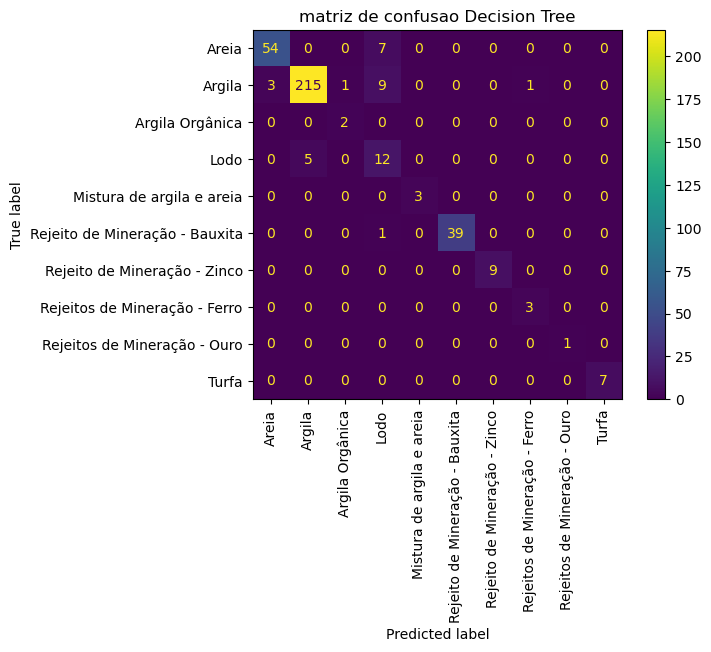

In [33]:
cm = model_confusion_matrix(DecisionTreeClassifier(random_state=0), smote=True)
plot_confusion_matrix(cm, "Decision Tree")

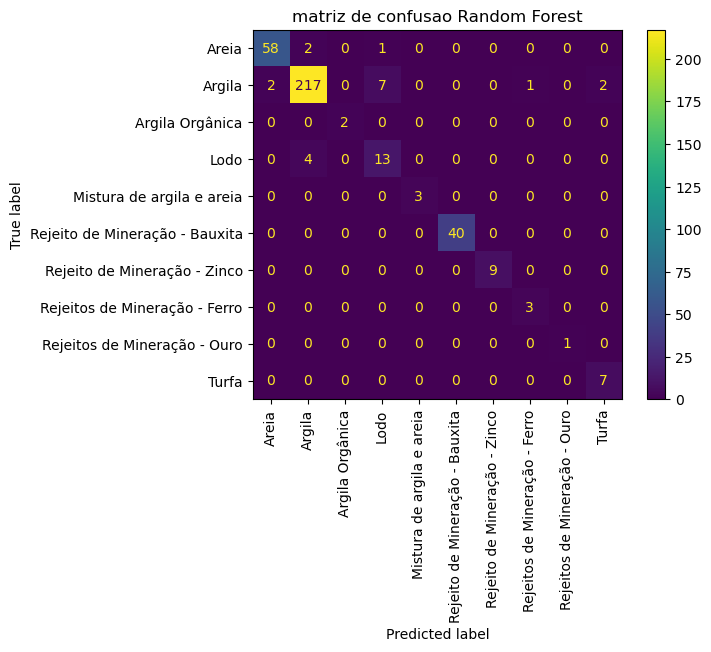

In [34]:
cm = model_confusion_matrix(RandomForestClassifier(random_state=0), smote=True)
plot_confusion_matrix(cm, "Random Forest")

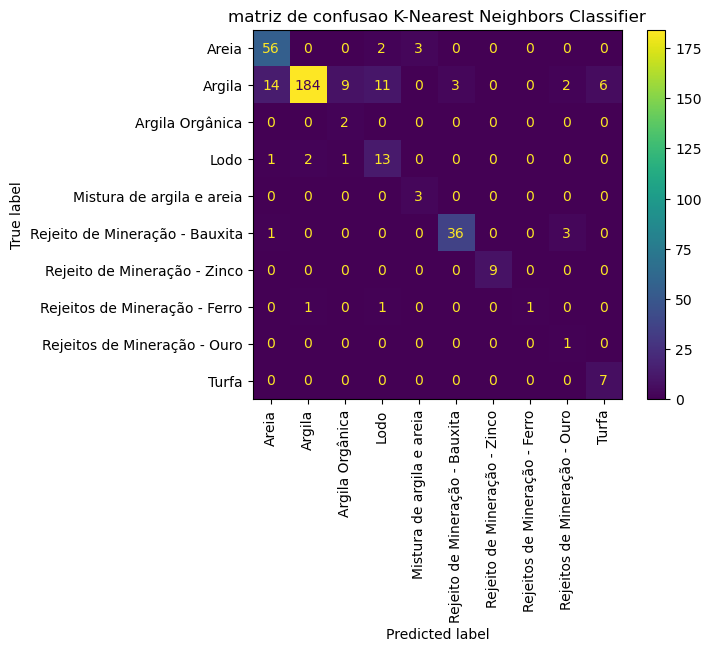

In [35]:
cm = model_confusion_matrix(KNeighborsClassifier(), smote=True)
plot_confusion_matrix(cm, "K-Nearest Neighbors Classifier")

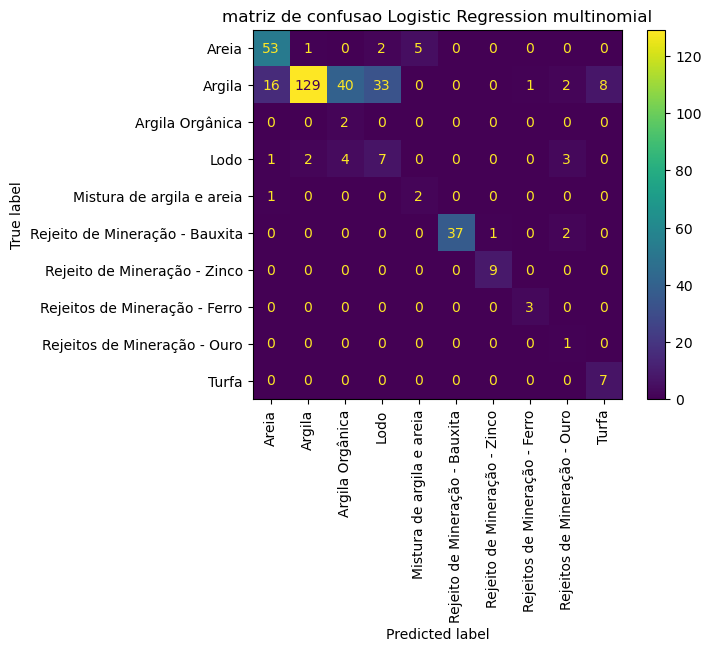

In [36]:
cm = model_confusion_matrix(LogisticRegression(random_state=0, max_iter=400, multi_class='multinomial'), smote=True)
plot_confusion_matrix(cm, "Logistic Regression multinomial")

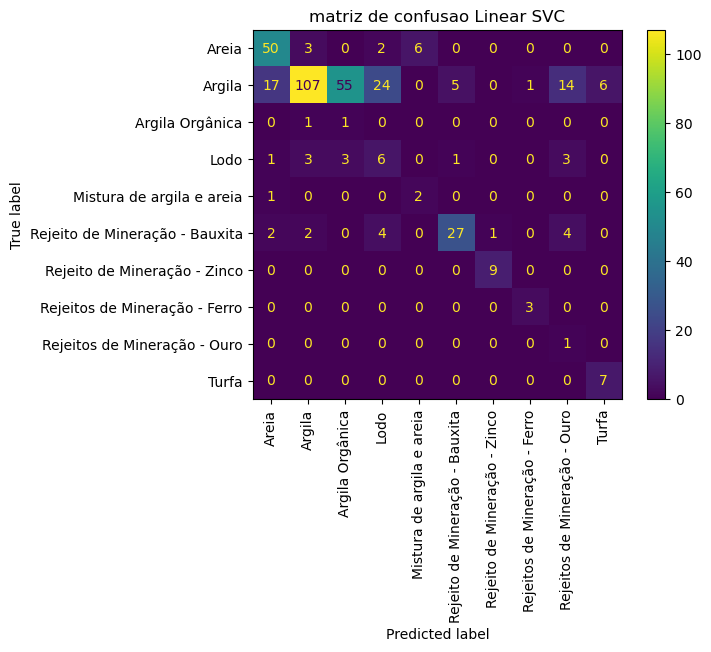

In [37]:
cm = model_confusion_matrix(LinearSVC(random_state=0), smote=True)
plot_confusion_matrix(cm, "Linear SVC")

### para imprimir tabelas bonitas e salvar pro excel

conda install -c anaconda jinja2 

conda install -c conda-forge xlsxwriter